In [1]:
import numpy as np
from time import strftime

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept.utils import TimeSeries

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def setup_model(exp_params):
    model = dict()
    model['tm'] = ec2b.TemporalModel(tsample=exp_params['tsample'])
    model['implant'] = e2cm.ArgusI(x_center=-1143.051, y_center=-271.21, h=100, rot=39.4*np.pi/180)
    
    # Create a retina that fits the implant
    round_to = 500  # round to nearest (microns)
    cspread = 500  # expected current spread (microns)
    xs = [a.x_center for a in model['implant']]
    ys = [a.y_center for a in model['implant']]
    xlo = np.floor((np.min(xs) - cspread) / round_to) * round_to
    xhi = np.ceil((np.max(xs) + cspread) / round_to) * round_to
    ylo = np.floor((np.min(ys) - cspread) / round_to) * round_to
    yhi = np.ceil((np.max(ys) + cspread) / round_to) * round_to
    model['retina'] = e2cm.Retina(sampling=exp_params['r_sampling'],
                                  xlo=xlo, xhi=xhi, ylo=ylo, yhi=yhi,
                                  axon_lambda=exp_params['axon_lambda'],
                                  rot=exp_params['r_rot_deg']*np.pi/180,
                                  loadpath=exp_params['save_dir'])
    
    # Plot axon bundles (plot every 5th for the sake of visualization)
    fig, ax = plt.subplots(1)
    ax.set_axis_bgcolor('black')
    ax.plot(model['retina'].jan_x[:, ::5], -model['retina'].jan_y[:, ::5],
            c=(0.5, 1, 0.5))

    # Plot location of implant on top of axon bundles
    for e in model['implant']:
        ax.text(e2cm.micron2deg(e.x_center + 10), -e2cm.micron2deg(e.y_center + 5),
                e.name, color='white', size='x-large')
        ax.plot(e2cm.micron2deg(e.x_center), -e2cm.micron2deg(e.y_center), 'ow',
                markersize=np.sqrt(e.radius))
    ax.set_aspect('equal')
    ax.set_xlim(-15, 15)
    ax.set_xlabel('visual angle (deg)')
    ax.set_ylim(-10, 10)
    ax.set_ylabel('visual angle (deg)')
    ax.set_title('Image flipped (upper retina = upper visual field)')
    fig.savefig(exp_params['save_dir'] + 'implant.eps')
    
    return model

In [3]:
def run_condition(idx_cond, exp_params, model):
    """Run a single condition of the Horsager experiment"""
    
    name_E1 = exp_params['name_E1']
    name_E2 = exp_params['name_E2']
    
    # Set up currents and delays
    if idx_cond == 1:
        # Condition 1: E1 fixed, all others zero
        amp_E1 = [exp_params['amp_ref']]
        amp_E2 = np.zeros_like(amp_E1)
        delays = [0]
    elif idx_cond == 2:
         # Condition 2: E2 fixed, all others zero
        amp_E2 = [exp_params['amp_ref']]
        amp_E1 = np.zeros_like(amp_E2)
        delays = [0]
    elif idx_cond == 3:
        # Condition 3: E1 fixed, E2 varies
        # Make current sum to 75% - 125% of amp_ref
        amp_E2 = np.linspace(0.3, 0.8, 3) * exp_params['amp_ref']
        amp_E1 = np.ones_like(amp_E2) * 0.35 * exp_params['amp_ref']
        delays = [0.075/1000, 0.375/1000, 1.8/1000, 9/1000]
    elif idx_cond == 4:
        # Condition 4: E2 fixed, E1 varies
        amp_E1 = np.linspace(0.3, 0.8, 3) * exp_params['amp_ref']
        amp_E2 = np.ones_like(amp_E1) * 0.35 * exp_params['amp_ref']
        delays = [0.075/1000, 0.375/1000, 1.8/1000, 9/1000]
    elif idx_cond == 5:
        # Condition 5: Both E1 and E2 vary
        amp_E1 = np.linspace(0.3, 0.8, 3) * exp_params['amp_ref']
        amp_E2 = np.linspace(0.3, 0.8, 3) * exp_params['amp_ref']
        delays = [0.075/1000, 0.375/1000, 1.8/1000, 9/1000]
    else:
        raise ValueError('Unknown idx_cond ' + str(idx_cond))
        
    data = dict()
    data['frames'] = []
    data['amp_E1'] = []
    data['amp_E2'] = []
    data['delay'] = []
    print ("- Condition %d" % idx_cond)
    for dd in delays:
        print("  - delay %.3f" % (dd*1000))
        
        for a1, a2 in zip(amp_E1, amp_E2):
            # generate list of pulse trains
            pt_e1 = get_pulse_train(a1, tsample=exp_params['tsample'])
            pt_e2 = get_pulse_train(a2, tsample=exp_params['tsample'], delay_dur=dd)
            pt = {name_E1: pt_e1, name_E2: pt_e2}
            resp = ec2b.pulse2percept(pt, model['implant'], model['tm'], model['retina'],
                                      use_ecs=exp_params['use_ecs'], tol=exp_params['tol'],
                                      n_jobs=8)

            # Find brightest frame
            brightest = ec2b.get_brightest_frame(resp)

            # Save data
            data['frames'].append(brightest)
            data['amp_E1'].append(a1)
            data['amp_E2'].append(a2)
            data['delay'].append(dd)
            
    return data

In [4]:
def run_experiment(exp_params, model):
    exp_params['date'] = strftime("%Y-%m-%d")
    print('Experiment: %s %s, %s' % (exp_params['name'], exp_params['name_E1'], exp_params['name_E2']))
    print('- Start time: %s %s' % (exp_params['date'], strftime("%H:%M:%S")))
    
    datapath = exp_params['save_dir']
    if not datapath.endswith('/'):
        datapath += '/'
    prefix = exp_params['name']
    electrodes = '%s_%s' % (exp_params['name_E1'], exp_params['name_E2'])
    suffix = '%s_%.1fX.npz' % (exp_params['date'], exp_params['fac_thresh'])

    # Check if we ran this experiment already
    import os
    for file in os.listdir(datapath):
        if file.startswith(prefix + '_' + electrodes):
            print('File that starts with %s%s_%s already exists, skip' % (datapath,
                                                                          prefix,
                                                                          electrodes))
            return

    # Generate filename and make sure we can write to it
    # Do this now rather than after hours of number crunching...
    filename = '%s%s_%s_%s' % (datapath, prefix, electrodes, suffix)
    np.savez(filename, data=np.zeros(10))
    os.remove(filename)
    print('- File: %s' % filename)
    exp_params['filename'] = filename

    # Run all 5 conditions
    data = dict()
    for idx_cond in range(5):
        name_cond = 'cond' + str(idx_cond + 1)
        data[name_cond] = run_condition(idx_cond + 1, exp_params, model)

    # Save results to .npz
    np.savez(filename, data=data, exp_params=exp_params, model=model)
    print('- Results saved to %s' % filename)
    print('- End time: %s' % strftime("%Y-%m-%d %H:%M:%S"))

In [5]:
# We could use ec2b.Psycho2Pulsetrain, but we'd like to have the stimulus first, 
# followed by the inter-pulse gap. ec2b.Psycho2Pulsetrain has the inter-pulse
# gap first...
def get_pulse_train(amp, tsample, delay_dur=0):
    freq = 50
    pulse_dur = 0.45/1000
    stim_dur = 0.5
    return e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=stim_dur, delay=delay_dur,
                                  pulse_dur=pulse_dur, interphase_dur=pulse_dur)

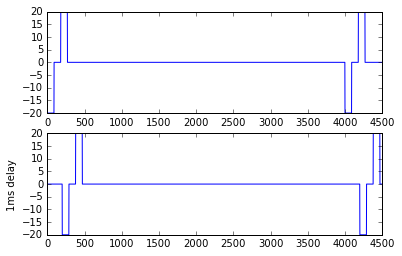

In [6]:
plt.subplot(211)
plt.plot(get_pulse_train(20, 5e-6, 0).data[0:4500])

plt.subplot(212)
plt.plot(get_pulse_train(20, 5e-6, 1/1000).data[0:4500])
plt.ylabel('1ms delay')

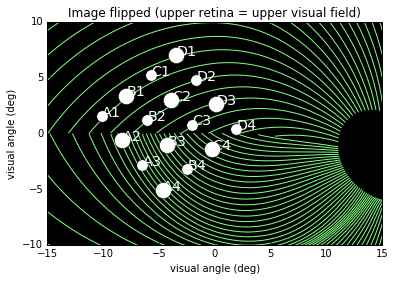

In [7]:
exp_params = dict()

# give the experiment a name
exp_params['name'] = 'TB-2009-03'

# sampling step in seconds
exp_params['tsample'] = 0.005 / 1000

# some factor x threshold
exp_params['fac_thresh'] = 1.5

# threshold current in micro amps
exp_params['amp_thresh'] = 15

# reference current at `fac_thresh` times threshold
exp_params['amp_ref'] = exp_params['fac_thresh'] * exp_params['amp_thresh']

# whether to use effective current map (True) or current map (False)
exp_params['use_ecs'] = True

exp_params['axon_lambda'] = 4
exp_params['r_sampling'] = 100
exp_params['r_rot_deg'] = 0
exp_params['tol'] = 0.5

# where to save the data (relative path)
exp_params['save_dir'] = '/home/mbeyeler/data/twopulse/lambda%.1f_%.2fX/' % (exp_params['axon_lambda'],
                                                                             exp_params['fac_thresh'])

model = setup_model(exp_params)

In [8]:
# all electrode pairs
name_E1 = ['C2','C1','B3','A1','A1','C4','A1','C3','C1','C3','B3','A4','B2','A2']
name_E2 = ['B2','D1','B1','C1','A4','C1','A2','C2','B1','B2','B2','B4','B4','C2']

for name1, name2 in zip(name_E1, name_E2):
    exp_params['name_E1'] = name1
    exp_params['name_E2'] = name2
    
    t_exe = %timeit -oq -n1 -r1 run_experiment(exp_params, model)
    print('- Experiment took %.1f s' % t_exe.best)

Experiment: TB-2009-03 C2, B2
- Start time: 2016-12-12 15:50:02
File that starts with /home/mbeyeler/data/twopulse/lambda4.0_1.50X/TB-2009-03_C2_B2 already exists, skip
- Experiment took 0.0 s
Experiment: TB-2009-03 C1, D1
- Start time: 2016-12-12 15:50:02
File that starts with /home/mbeyeler/data/twopulse/lambda4.0_1.50X/TB-2009-03_C1_D1 already exists, skip
- Experiment took 0.0 s
Experiment: TB-2009-03 B3, B1
- Start time: 2016-12-12 15:50:02
File that starts with /home/mbeyeler/data/twopulse/lambda4.0_1.50X/TB-2009-03_B3_B1 already exists, skip
- Experiment took 0.0 s
Experiment: TB-2009-03 A1, C1
- Start time: 2016-12-12 15:50:02
File that starts with /home/mbeyeler/data/twopulse/lambda4.0_1.50X/TB-2009-03_A1_C1 already exists, skip
- Experiment took 0.0 s
Experiment: TB-2009-03 A1, A4
- Start time: 2016-12-12 15:50:02
File that starts with /home/mbeyeler/data/twopulse/lambda4.0_1.50X/TB-2009-03_A1_A4 already exists, skip
- Experiment took 0.0 s
Experiment: TB-2009-03 C4, C1
- Sta